# Draw graph for annotated data

In [19]:
import datetime
import os
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [34]:
DATADIRTEXT = "../data/text/"
DATADIRLABELS = "../data/"
DATE = "date"
IDSTR = "id_str"
INFILENAME = DATADIRLABELS+"distance-tweets.csv.human-labels.txt"
IRRELEVANT = "ANDERS"
LABEL = "label"
REJECTS = "ONEENS"
SCORE = "score"
SUPPORTS = "EENS"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [4]:
mainAnnotator = ""
labeledData = {}
inFile = open(INFILENAME,"r")
for line in inFile:
    fields = line.strip().split()
    annotator = fields[0]
    if mainAnnotator == "": mainAnnotator = annotator
    if annotator == mainAnnotator:
        idStr = str(fields[2])
        label = fields[4]
        labeledData[idStr] = {LABEL:label}
inFile.close()
len(labeledData)

5977

In [5]:
def convertFileNameToDate(inFileName):
    return(inFileName[0:8])

In [6]:
labeledIds = set(labeledData.keys())
inFileNames = sorted(os.listdir(DATADIRTEXT))
for inFileName in inFileNames:
    if re.search("^2.*z$",inFileName):
        squeal(inFileName)
        date = convertFileNameToDate(inFileName)
        df = pd.read_csv(DATADIRTEXT+inFileName,dtype={IDSTR:"str"})
        for idStr in labeledIds.intersection(set(df[IDSTR])):
            labeledData[idStr][DATE] = date

20200731-23.out.gz


In [7]:
len([i for i in labeledData.keys() if DATE in labeledData[i]])

5968

In [8]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [9]:
dateCounts = {}
for idStr in labeledData:
    if DATE in labeledData[idStr]:
        date = labeledData[idStr][DATE]
        if not date in dateCounts: dateCounts[date] = {SUPPORTS:0,REJECTS:0,IRRELEVANT:0}
        dateCounts[date][labeledData[idStr][LABEL]] += 1
dateCounts = {date:dateCounts[date][SUPPORTS]/(dateCounts[date][SUPPORTS]+dateCounts[date][REJECTS]) \
              for date in sorted(dateCounts.keys()) \
              if dateCounts[date][SUPPORTS]+dateCounts[date][REJECTS] > 0}

In [15]:
STARTDATENBR = 8

list(dateCounts.keys())[STARTDATENBR]

'20200310'

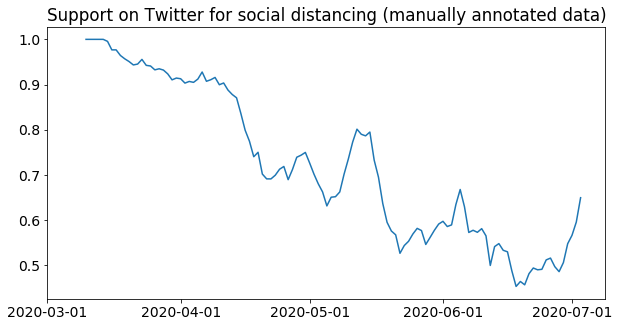

In [22]:
DATEFORMAT = "%Y%m%d"
WEEKSIZE = 7
PLOTFILENAME = "social-distancing-annotated.png"

x = [datetime.datetime.strptime(date,DATEFORMAT) for date in dateCounts.keys()][STARTDATENBR:]
y = movingAverage(list(dateCounts.values()),WEEKSIZE)[STARTDATENBR:]
plt.figure(figsize=(10,5))
font = {"size":14}
matplotlib.rc("font",**font)
plt.plot_date(x,y,fmt="-")
plt.title("Support on Twitter for social distancing (manually annotated data)")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701".split()])
plt.savefig()
plt.show()

In [35]:
OUTFILENAME = "manual-annotation.csv"

pd.DataFrame([dateCounts]).T.to_csv(OUTFILENAME,header=[SCORE],index_label=DATE)